Taken from [this tutorial](https://github.com/keras-team/keras-io/blob/master/examples/vision/knowledge_distillation.py)

In [1]:
"""
## Setup
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [3]:
"""
## Prepare the dataset
The dataset used for training the teacher and distilling the teacher is
[MNIST](https://keras.io/api/datasets/mnist/), and the procedure would be equivalent for any other
dataset, e.g. [CIFAR-10](https://keras.io/api/datasets/cifar10/), with a suitable choice
of models. Both the student and teacher are trained on the training set and evaluated on
the test set.
"""

# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
from skimage.transform import resize

def resize_img(data):
    output = np.zeros((data.shape[0],64))
    for i, img in enumerate(data):
        output[i]=resize(img, (8,8)).flatten()
    return output

x_train_small = resize_img(x_train/255.0)
x_test_small = resize_img(x_test/255.0)


#bottle_resized = resize(bottle, (140, 54))

In [7]:
# Normalize data
x_train = x_train_small.astype("float32") * 16.0
x_train = np.reshape(x_train, (-1, 64))

x_test = x_test_small.astype("float32") * 16.0
x_test = np.reshape(x_test, (-1, 64))

In [9]:
np.min(x_train)

0.0

In [119]:
latent_dim = 3

encoder_inputs = keras.Input(shape=64)
x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(48, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense_91 (Dense)                (None, 64)           4160        input_32[0][0]                   
__________________________________________________________________________________________________
dense_92 (Dense)                (None, 48)           3120        dense_91[0][0]                   
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 32)           1568        dense_92[0][0]                   
____________________________________________________________________________________________

In [120]:
latent_inputs = keras.Input(shape=latent_dim)
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(48, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
decoder_outputs = layers.Dense(64, activation="relu")(x)
#decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_95 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_96 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_97 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                3136      
_________________________________________________________________
dense_99 (Dense)             (None, 64)                4160      
Total params: 9,488
Trainable params: 9,488
Non-trainable params: 0
_________________________________________________________

In [121]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
            reconstruction_loss = mse(data,reconstruction)
            #tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.binary_crossentropy(tf.math.divide(data,16.0), tf.math.divide(reconstruction,16.0), axis=1)
            #    )
            #)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 10*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [122]:
from keras import backend as K
K.set_value(vae.optimizer.learning_rate, 0.0001)

In [123]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 4s 8ms/step - loss: 1145.4556 - reconstruction_loss: 826.6804 - kl_loss: 4.6059
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 708.9396 - reconstruction_loss: 656.8228 - kl_loss: 4.3331
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 622.4504 - reconstruction_loss: 543.7074 - kl_loss: 5.6034
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 564.0025 - reconstruction_loss: 500.9315 - kl_loss: 5.8368
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 546.0344 - reconstruction_loss: 485.3413 - kl_loss: 5.9371
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 538.1742 - reconstruction_loss: 473.4655 - kl_loss: 6.0512
Epoch 7/30
469/469 [==============================] - 4s 10ms/step - loss: 466.0218 - reconstruction_loss: 370.5117 - kl_loss: 6.2666
Epoch 8/30
469/469 [==============================] - 5s 10ms/step 

In [124]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, zn=10, figsize=15, scale = 1.0):
    # display a n*n 2D manifold of digits
    digit_size = 8
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    grid_z = np.linspace(-scale, scale, zn)[::-1]
    pos=0
    for k, zi in enumerate(grid_z):
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                z_sample = np.array([[xi, yi, zi]])
                x_decoded = vae.decoder.predict(z_sample)
                digit = 1-x_decoded[0].reshape(digit_size, digit_size)/16.0
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit
                pos+=1

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0] (z[2]="+str(zi)+")")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap="Greys_r")
        plt.show()

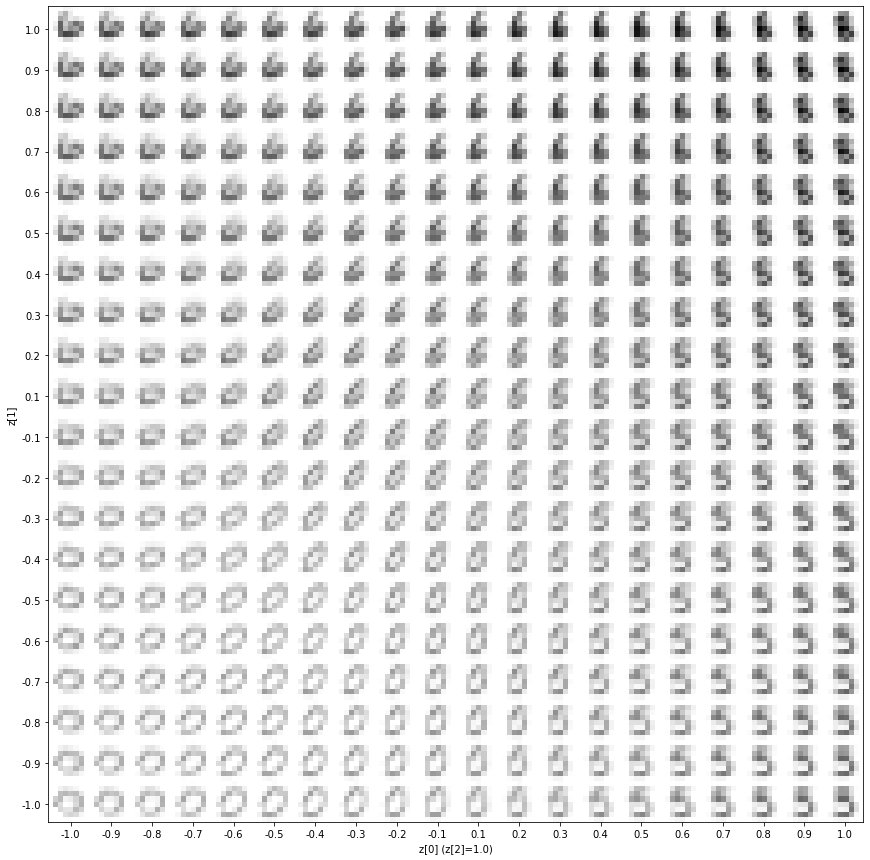

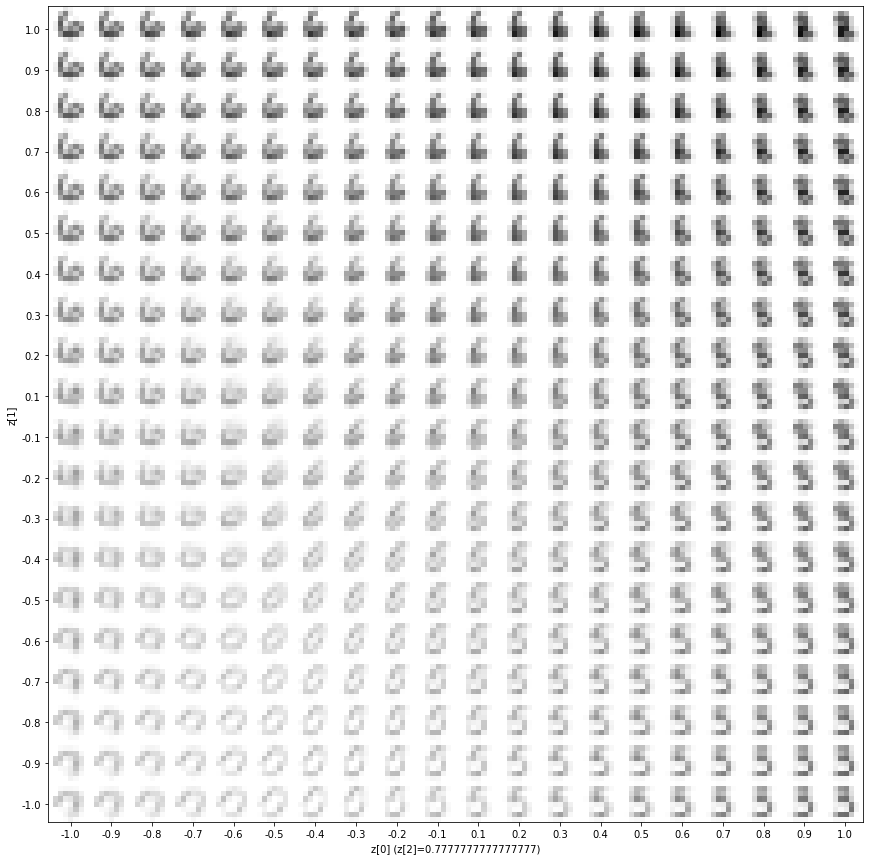

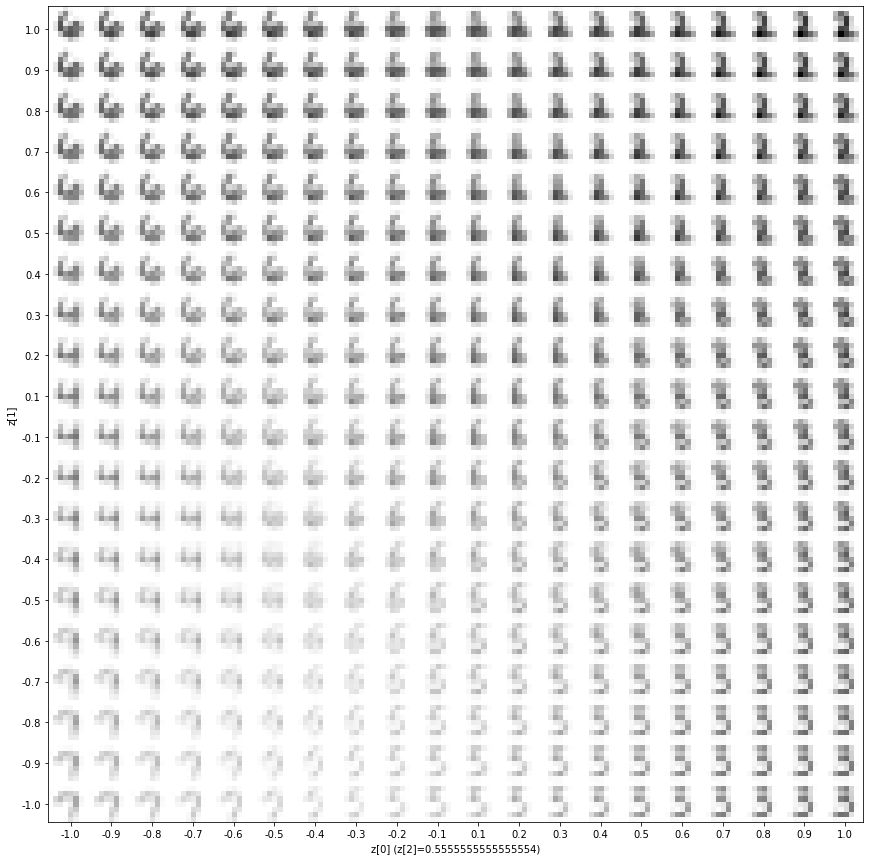

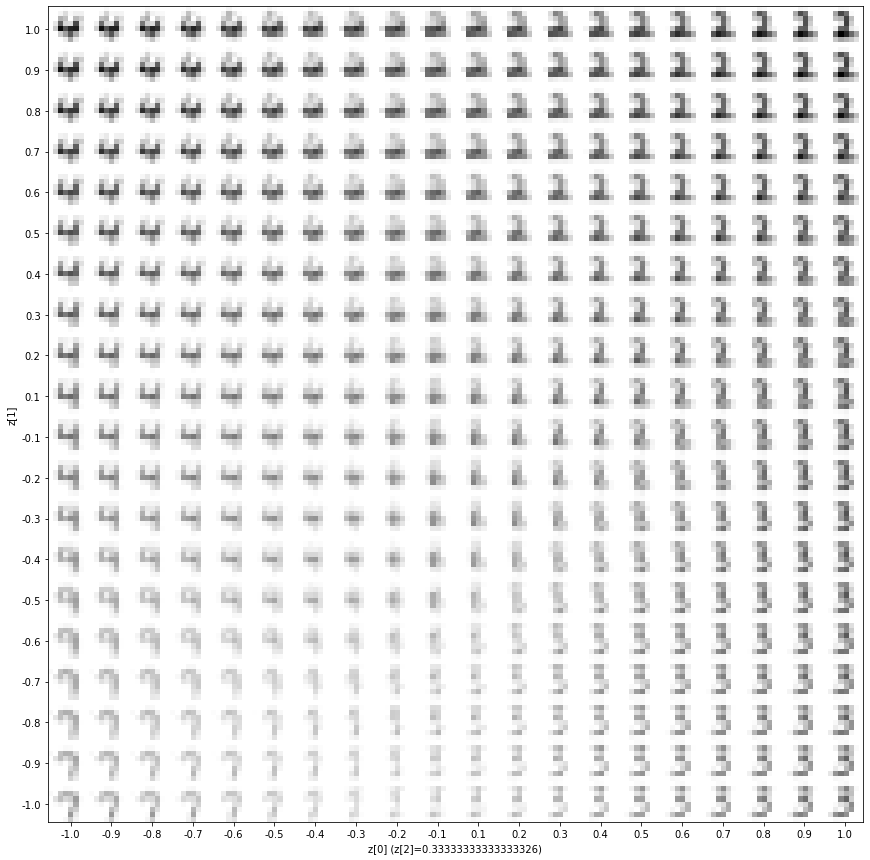

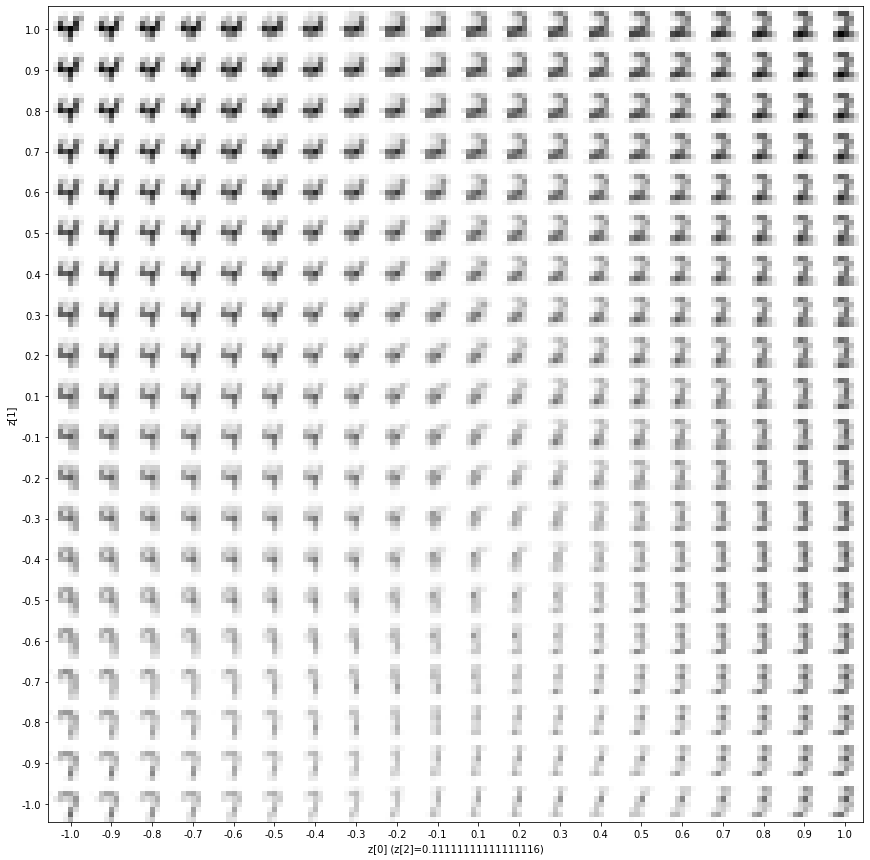

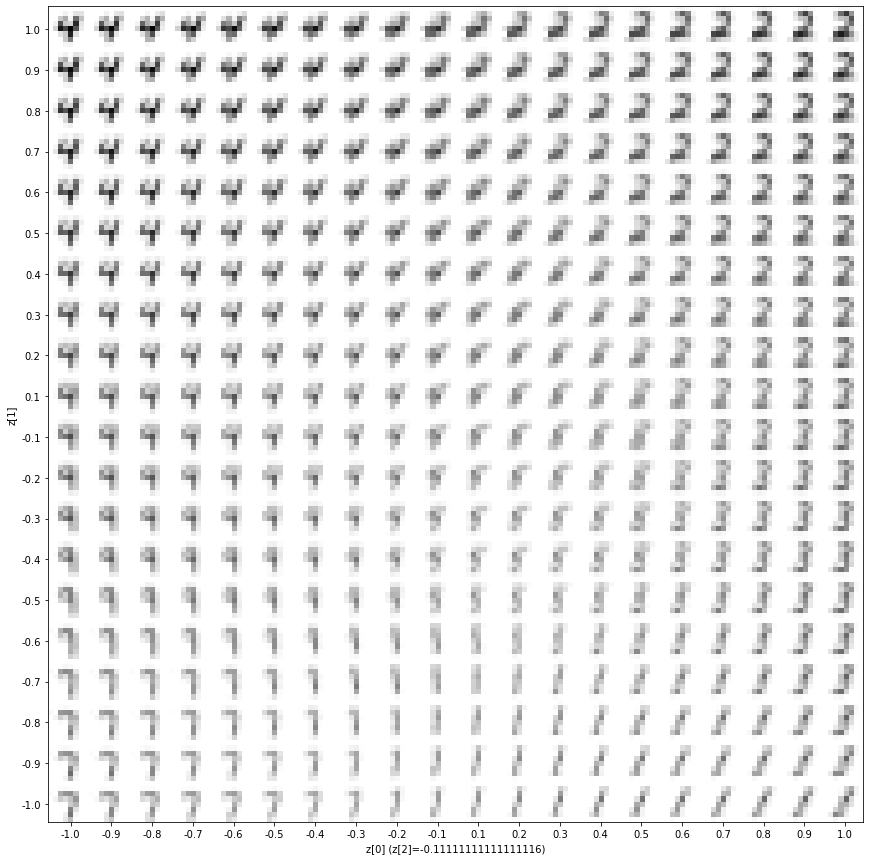

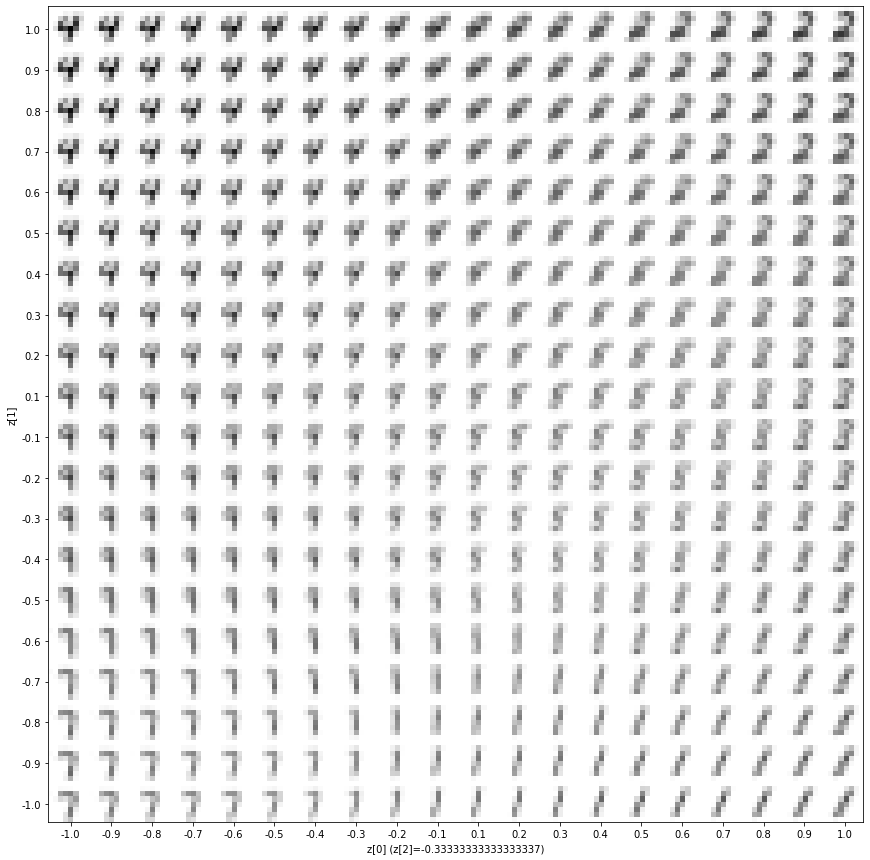

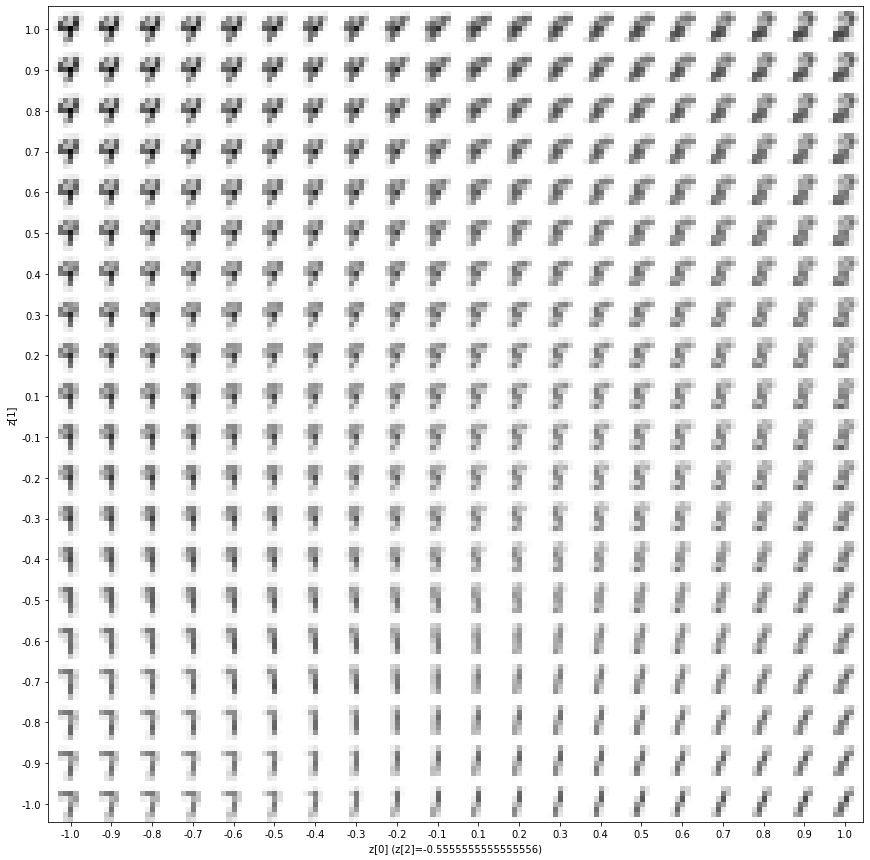

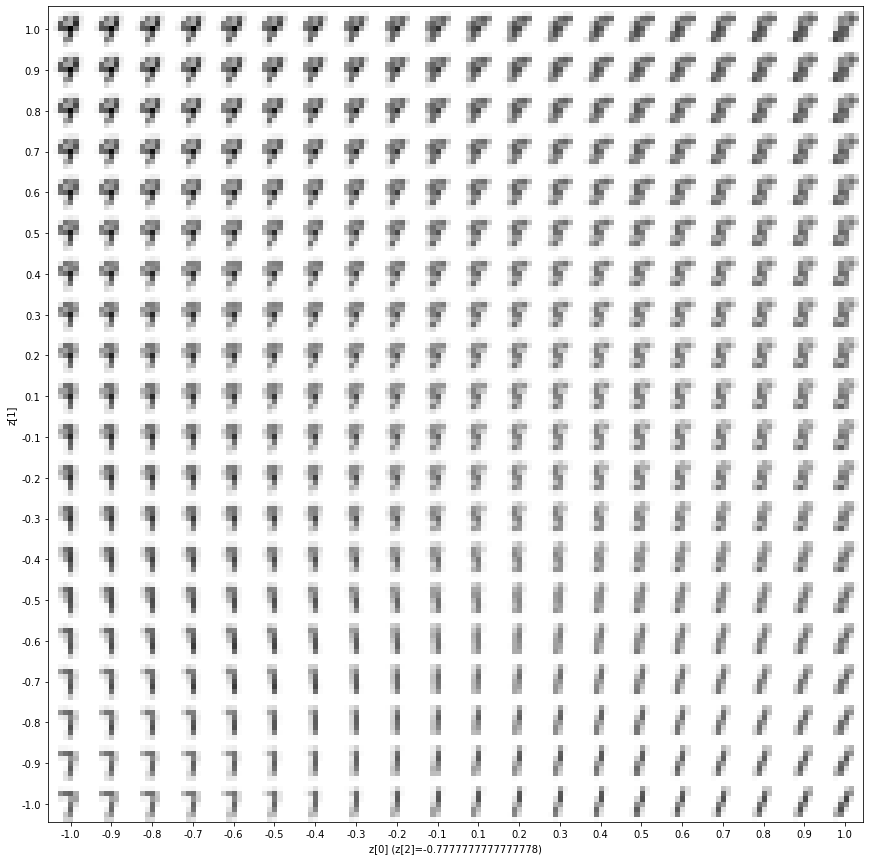

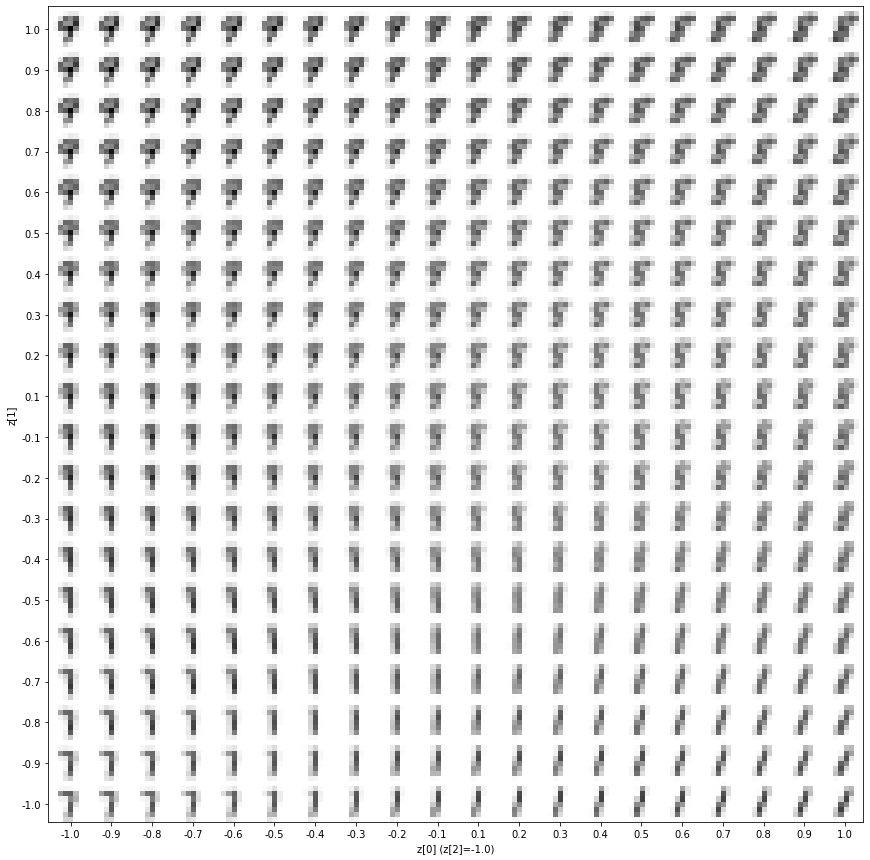

In [125]:
plot_latent_space(vae,n=20)

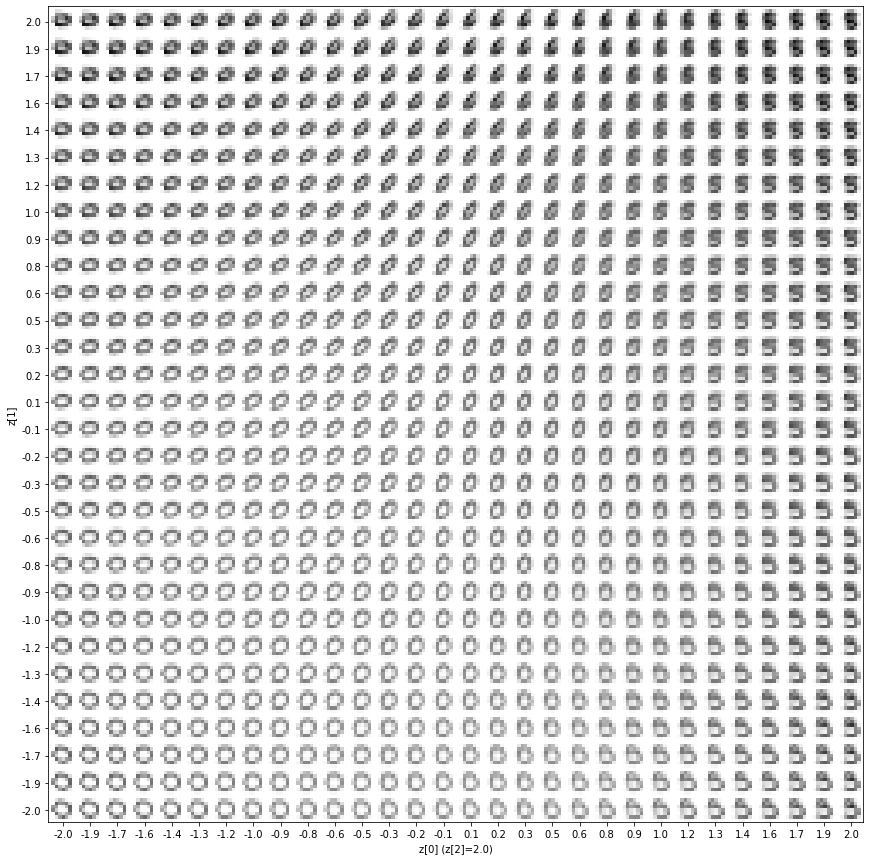

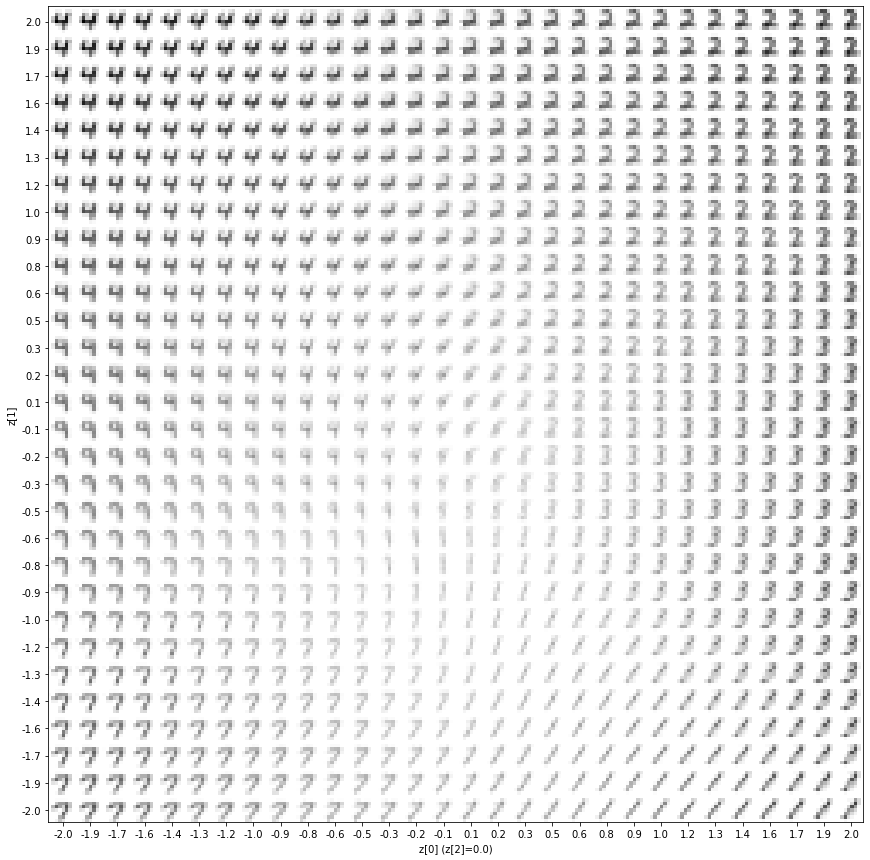

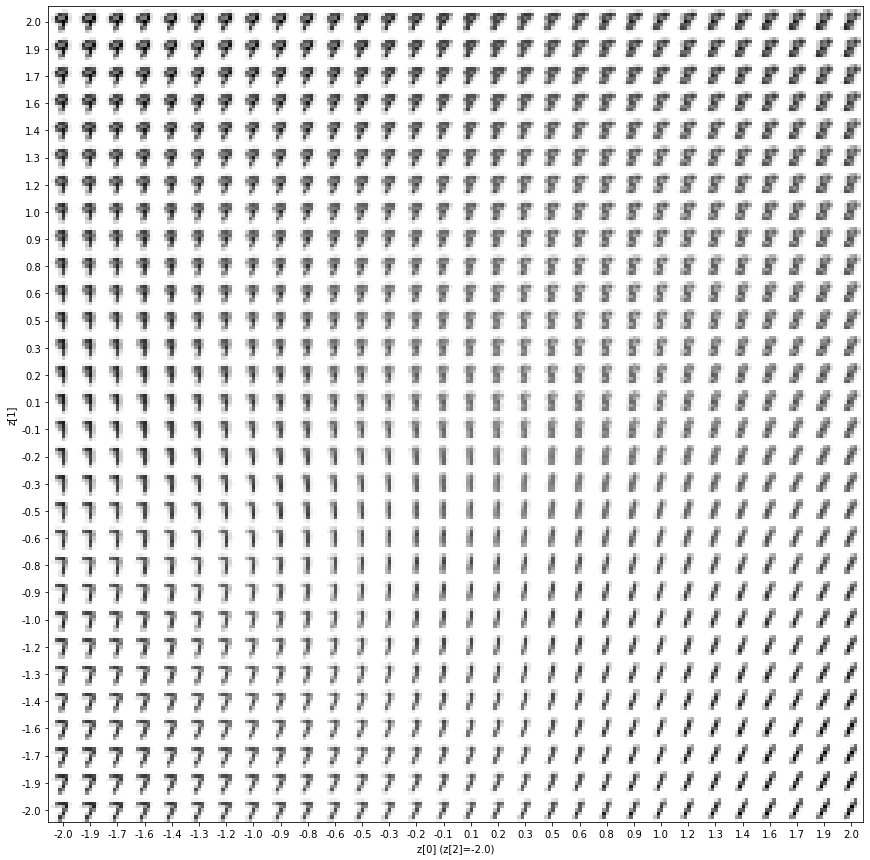

In [126]:
plot_latent_space(vae, scale=2.0,zn=3)

In [127]:
encoder.save("mnist8x8_encode.h5")

In [128]:
decoder.save("mnist8x8_decode.h5")

In [132]:
from tensorflow.python.keras.models import load_model
model = load_model('mnist8x8_100_80_60_40_20_10.h5')

In [137]:
main_with_decoder = keras.Sequential()
for l in decoder.layers:
    main_with_decoder.add(l)
for l in model.layers:
    main_with_decoder.add(l)

In [139]:
main_with_decoder.summary()
main_with_decoder.save('mnist8x8_auto_100_80_60_40_20_10.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_96 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_97 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                3136      
_________________________________________________________________
dense_99 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_37 (Dense)             (None, 80)                8

In [140]:
mirrormodel = load_model('mnist8x8_100_80_60_40_20_10-mirror.h5')

In [141]:
mirror_with_decoder = keras.Sequential()
for l in decoder.layers:
    mirror_with_decoder.add(l)
for l in mirrormodel.layers:
    mirror_with_decoder.add(l)

In [142]:
mirror_with_decoder.summary()
mirror_with_decoder.save('mnist8x8_auto_100_80_60_40_20_10-mirror.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_96 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_97 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                3136      
_________________________________________________________________
dense_99 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 40)                2600      
_________________________________________________________________
dense_43 (Dense)             (None, 40)               

In [143]:
import onnx
import keras2onnx

In [147]:
model = load_model("mnist8x8_auto_100_80_60_40_20_10.h5")
model.compile()

In [148]:
onnx_model = keras2onnx.convert_keras(model, main_with_decoder.name)
onnx.save_model(model, "mnist8x8_auto_100_80_60_40_20_10.onnx")

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 37 -> 32
The maximum opset needed by this model is only 9.


AttributeError: 'Sequential' object has no attribute 'graph'